## Data preparation

In [1]:
import numpy as np
import scipy
import os
import sklearn as skl
import pandas as pd
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import pylab as plt
from pandas.plotting import scatter_matrix
#import librosa  #need install first
#import librosa.display

In [2]:
# Load metadata and features - change to local directory for tracks file
tracks = pd.read_csv('tracks.csv', header=None)
echonest = pd.read_csv('echonest.csv', header=None)

C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,11,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,1

In [3]:
# Change column names from "track.1", ... to named columns
header = tracks.iloc[1]
header[0] = 'track_ID'
tracks.drop(tracks.index[[0,1,2]], inplace=True)
tracks.rename(columns=header, inplace=True)
tracks.head()

header = echonest.iloc[2]
header[0]='track_ID'
echonest.drop(echonest.index[[0,1,2,3]],inplace=True)
echonest.rename(columns = header,inplace=True)
echonest.head()

# Only select songs for which we have echonest data
tracks_with_echonest_data = tracks[tracks['track_ID'].isin(echonest['track_ID'])]
echonest_data = echonest[echonest['track_ID'].isin(tracks_with_echonest_data['track_ID'])]

merged_echonest_data = pd.merge(tracks_with_echonest_data, echonest_data, on = 'track_ID')

# Change duplicate "listens" column to track listens and album listens
duplicate_listens = {'listens': ['album_listens', 'track_listens']}

merged_echonest_data = merged_echonest_data.rename(columns=lambda c: duplicate_listens[c].pop(0) if c in duplicate_listens.keys() else c)

In [4]:
# Extract year released from release date variable
album_release_year = []

for x in merged_echonest_data['date_released']:
    if type(x)==str:
        album_release_year.append(x[0:4])
    else: 
        album_release_year.append(np.nan)

#add album release year to dataframe
merged_echonest_data['album_release_year'] = album_release_year

# Check number of songs released per year and pick year with maximum
import collections
counter=collections.Counter(album_release_year)
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(3))

Counter({nan: 3140, '2010': 1461, '2009': 1426, '2011': 1101, '2008': 1088, '2007': 464, '2012': 380, '2006': 346, '2013': 298, '2014': 245, '2004': 167, '2005': 150, '2015': 145, '2003': 94, '2002': 84, '2001': 69, '1999': 68, '2000': 34, '1997': 25, '1995': 20, '1982': 19, '1998': 17, '1996': 10, '1986': 10, '1981': 6, '1973': 5, '1985': 5, '1992': 3, '1913': 2, '1976': 2, '1912': 1, '1916': 1, '1911': 1, '1909': 1, '1905': 1, '1907': 1, '1988': 1, '1902': 1})
dict_values([1426, 1088, 464, 150, 20, 346, 3140, 94, 19, 6, 69, 84, 167, 34, 68, 10, 1, 1, 1, 2, 1, 1, 1, 25, 3, 1, 17, 1461, 2, 10, 1101, 5, 245, 380, 298, 5, 1, 145])
dict_keys(['2009', '2008', '2007', '2005', '1995', '2006', nan, '2003', '1982', '1981', '2001', '2002', '2004', '2000', '1999', '1996', '1912', '1916', '1911', '1913', '1909', '1905', '1907', '1997', '1992', '1988', '1998', '2010', '1976', '1986', '2011', '1973', '2014', '2012', '2013', '1985', '1902', '2015'])
[(nan, 3140), ('2010', 1461), ('2009', 1426)]


In [5]:
# For chosen year, check the number of songs released per genre; pick top three genres to use
tracks_2010 = merged_echonest_data[merged_echonest_data['album_release_year'] == '2010']

# Top genres for 2010
counter=collections.Counter(tracks_2010['genre_top'])
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(10))

Counter({nan: 524, 'Rock': 372, 'Electronic': 271, 'Hip-Hop': 133, 'Folk': 67, 'Pop': 58, 'Jazz': 23, 'International': 12, 'Instrumental': 1})
dict_values([23, 372, 58, 271, 524, 133, 67, 12, 1])
dict_keys(['Jazz', 'Rock', 'Pop', 'Electronic', nan, 'Hip-Hop', 'Folk', 'International', 'Instrumental'])
[(nan, 524), ('Rock', 372), ('Electronic', 271), ('Hip-Hop', 133), ('Folk', 67), ('Pop', 58), ('Jazz', 23), ('International', 12), ('Instrumental', 1)]


In [48]:
# Add sentiment analysis by title into dataset - compound score of positive / negative sentiment for song title
# Rulan
# require to install nltk first
# this part work nice, file will be generated to our project folder. 

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Read in track data - change to local directory
tracks_senti = pd.read_csv('tracks.csv',header=None)

header = tracks_senti.iloc[1]
header[0]='track ID'
header[52]='track title'
tracks_senti.drop(tracks_senti.index[[0,1,2]],inplace=True)
tracks_senti.rename(columns = header,inplace=True)
tracks_senti.head()

df=tracks_senti[['track ID','track title']]
df.dropna(axis=0, how='any')

ml = df["track title"].values
title=[]
for i in range(len(ml)):
    a=str(ml[i])
    title.append(a)
idd = df["track ID"].values

neg=[]
neu=[]
pos=[]
comp=[]

sid = SentimentIntensityAnalyzer()
for sentence in title:
    ss = sid.polarity_scores(sentence)
    score=[]
    for k in ss:
        a=ss[k]
        score.append(a)
    neg.append(score[0])
    neu.append(score[1])
    pos.append(score[2])
    comp.append(score[3])

sentimentall = pd.DataFrame({'track_ID':idd,'track_title':title,'senti neg': neg,'senti neu': neu,'senti pos': pos,'senti comp': comp})

sentimentall.to_csv('sentimental_analysis_title.csv')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\qusac\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Add sentiment to dataframe
sentiment= pd.read_csv('sentimental_analysis_title.csv')
sentiment=sentiment[['track_ID','senti comp', 'senti neg','senti pos']]
tracks_2010 = pd.merge(tracks_2010, sentiment, how='inner', on=['track_ID'])
tracks_2010.head()

,track_ID,comments,date_created,date_released,engineer,favorites,id,information,album_listens,producer,...,218,219,220,221,222,223,album_release_year,senti comp,senti neg,senti pos
0,26531,0,2010-03-02 06:00:32,2010-03-02 00:00:00,NaN,2,5763,<p>Improvising music is probably the best exam...,7260,NaN,...,0.0947888,0.06272,3.30952,3.2468,3.4673,19.3287,2010,0.0,0.0,0.0
1,26532,0,2010-03-02 06:00:32,2010-03-02 00:00:00,NaN,2,5763,<p>Improvising music is probably the best exam...,7260,NaN,...,0.556985,0.07887,10.1641,10.0852,6.203,52.9757,2010,0.0,0.0,0.0
2,26533,0,2010-03-02 06:00:32,2010-03-02 00:00:00,NaN,2,5763,<p>Improvising music is probably the best exam...,7260,NaN,...,0.131889,0.06363,8.14385,8.08022,8.10984,117.875,2010,0.0,0.0,0.0
3,26534,0,2010-03-02 06:00:32,2010-03-02 00:00:00,NaN,2,5763,<p>Improvising music is probably the best exam...,7260,NaN,...,0.118238,0.06381,7.81628,7.75247,8.11471,123.621,2010,0.0,0.0,0.0
4,27223,0,2010-03-14 11:40:47,2010-03-14 00:00:00,NaN,3,5883,<p>The Sakee Sed are Marco Grezzi and Gianluca...,6282,NaN,...,0.0100094,0.08762,0.70132,0.6137,1.18583,2.11265,2010,0.0,0.0,0.0


In [8]:
# Select the variables we want - named variables 
t10 = tracks_2010[['track_ID','latitude','longitude','bit_rate','duration','genre_top','track_listens','acousticness','danceability','energy','instrumentalness','liveness','speechiness','tempo','valence','artist_hotttnesss','artist_discovery','artist_familiarity', 'senti neg','senti pos']]

# For location (latitude, longitude), if na, change to 0
t10['latitude'].fillna(0, inplace=True)
t10['longitude'].fillna(0, inplace=True)

# For genre-specific models - split dataset into three based on top three genres
Hiphop_10=t10.loc[t10['genre_top'] == 'Hip-Hop']
Rock_10=t10.loc[t10['genre_top'] == 'Rock']
Elec_10=t10.loc[t10['genre_top'] == 'Electronic']

# For baseline model - add genre as a categorical variable 
t10['Rock'] = (t10['genre_top'] == 'Rock').astype(int)
t10['Hip-Hop'] = (t10['genre_top'] == 'Hip-Hop').astype(int)
t10['Electronic'] = (t10['genre_top'] == 'Electronic').astype(int)
t10.drop(['genre_top'], axis=1)

t10.head()

C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

,track_ID,latitude,longitude,bit_rate,duration,genre_top,track_listens,acousticness,danceability,energy,...,tempo,valence,artist_hotttnesss,artist_discovery,artist_familiarity,senti neg,senti pos,Rock,Hip-Hop,Electronic
0,26531,55.323094,23.89589,320000,324,Jazz,1532,0.981185,0.462934,0.113998,...,73.941,0.273272,0.266514,0.255115,0.271908,0.0,0.0,0,0,0
1,26532,55.323094,23.89589,320000,431,Jazz,1506,0.988642,0.421825,0.210379,...,125.2,0.117733,0.266514,0.255115,0.271908,0.0,0.0,0,0,0
2,26533,55.323094,23.89589,320000,688,Jazz,359,0.992052,0.449904,0.187091,...,82.752,0.143674,0.266514,0.255115,0.271908,0.0,0.0,0,0,0
3,26534,55.323094,23.89589,320000,782,Jazz,381,0.988513,0.299413,0.212382,...,74.872,0.126995,0.266514,0.255115,0.271908,0.0,0.0,0,0,0
4,27223,41.871940,12.56738,320000,209,Rock,260,0.403708,0.679438,0.732271,...,124.293,0.826063,0.414522,0.396793,0.296588,0.0,0.0,1,0,0


In [9]:
# Take hip-hop, rock, and hip-hop together
t10['g']=t10['Rock']+ t10['Hip-Hop'] +t10['Electronic']
t10=t10.loc[t10['g'] == 1]
t10.drop(['g'],axis=1,inplace=True)

# only genres Hiphop, Rock and Electronic (separate dataframes)
Hiphop_10.drop(['genre_top'],axis=1,inplace=True)
Rock_10.drop(['genre_top'],axis=1,inplace=True)
Elec_10.drop(['genre_top'],axis=1,inplace=True)

C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
Hiphop_10.head()

,track_ID,latitude,longitude,bit_rate,duration,track_listens,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,artist_hotttnesss,artist_discovery,artist_familiarity,senti neg,senti pos
144,29261,40.782997,-73.520511,320000,194,1051,0.3354,0.77322,0.581333,0.658409,0.115304,0.11509,99.978,0.902166,0.421518,0.40349,0.173197,0.0,0.63
145,29262,0.000000,0.000000,320000,125,601,0.129724,0.912699,0.471803,0.00410112,0.577598,0.211598,100.003,0.411787,0.3784,0.362216,0.302471,0.0,0.00
149,29266,0.000000,0.000000,320000,218,985,0.0167058,0.618888,0.353098,0.127126,0.0458901,0.328308,167.799,0.702269,0.36043,0.345015,0.321812,0.0,0.00
184,30230,41.877521,-87.611232,320000,112,952,0.328027,0.728172,0.788149,0.00115396,0.673191,0.214802,85.703,0.884179,0.402054,0.384858,0.326596,0.0,0.00
185,30231,41.877521,-87.611232,320000,228,359,0.213706,0.763116,0.6256,0.00156461,0.12079,0.421819,91.528,0.8604,0.402054,0.384858,0.326596,0.0,0.00


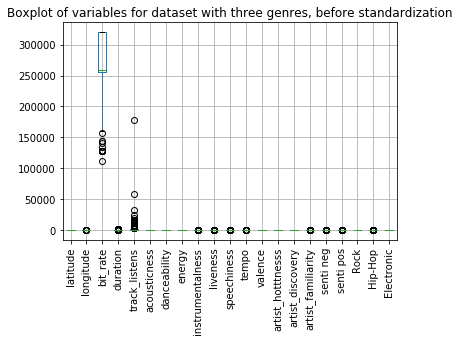

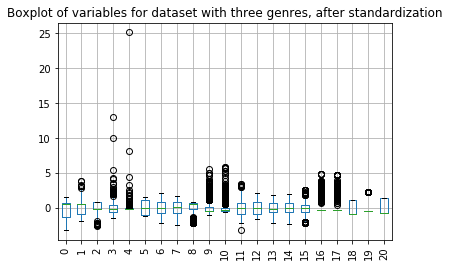

In [11]:
# Make boxplot of variables for t10 data (data with all three genres) - before standardization 
t10.drop(['track_ID', 'genre_top'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with three genres, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for t10 data (data with all three genres) - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
t10_scaled = scaler.fit_transform(t10.drop(['track_ID', 'genre_top'], axis=1))
t10_scaled = pd.DataFrame(t10_scaled)
t10_scaled.rename(columns={'0': 'latitude', '1':'longitude'}, inplace=True)

t10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with three genres, after standardization')
plt.xticks(rotation=90)
plt.show()

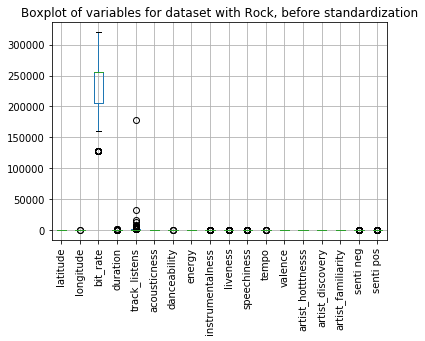

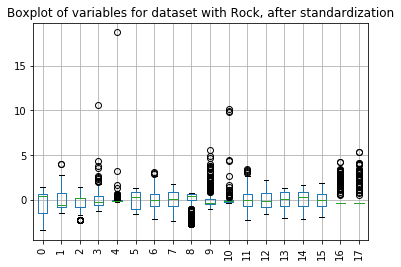

In [12]:
# Make boxplot of variables for rock data - before standardization 
Rock_10.drop(['track_ID'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Rock, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for rock data - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Rock_10_scaled = scaler.fit_transform(Rock_10.drop(['track_ID'], axis=1))
Rock_10_scaled = pd.DataFrame(Rock_10_scaled)
Rock_10_scaled.rename(columns={'0': 'latitude', '1':'longitude'}, inplace=True)

Rock_10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Rock, after standardization')
plt.xticks(rotation=90)
plt.show()

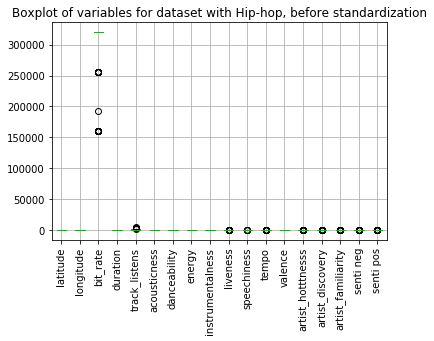

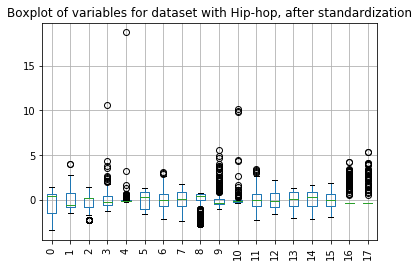

In [13]:
# Make boxplot of variables for hiphop data - before standardization 
Hiphop_10.drop(['track_ID'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Hip-hop, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for hiphop data - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Hiphop_10_scaled = scaler.fit_transform(Rock_10.drop(['track_ID'], axis=1))
Hiphop_10_scaled = pd.DataFrame(Hiphop_10_scaled)
Hiphop_10_scaled.rename(columns={'0': 'latitude', '1':'longitude'}, inplace=True)

Hiphop_10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Hip-hop, after standardization')
plt.xticks(rotation=90)
plt.show()

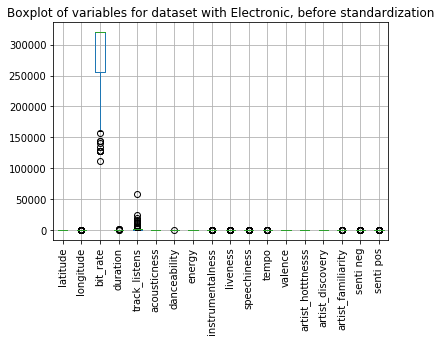

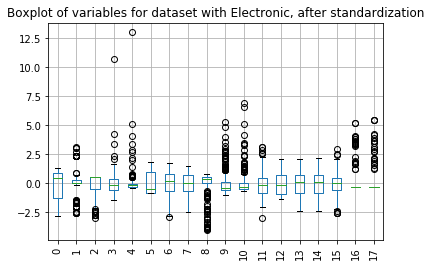

In [14]:
# Make boxplot of variables for electronic data - before standardization 
Elec_10.drop(['track_ID'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Electronic, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for electronic data - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Elec_10_scaled = scaler.fit_transform(Elec_10.drop(['track_ID'], axis=1))
Elec_10_scaled = pd.DataFrame(Elec_10_scaled)
Elec_10_scaled.rename(columns={'0': 'latitude', '1':'longitude'}, inplace=True)

Elec_10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Electronic, after standardization')
plt.xticks(rotation=90)
plt.show()

In [15]:
# Make boxplots of variables in genre dataset 
# Sa

# Standardize variables as needed
# Sa


## Exploratory analysis

In [ ]:
# Check for correlation between variables with correlation plot 
# Kathy

# Check for correlation between arist hotness, familiarity, discovery
# Kathy

In [13]:
# Make scatter plots of numerical variables versus outcome (track listens)
# Rulan

plt.scatter(tracks.track_listens,tracks.acousticness)
plt.ylabel('track_listens')
plt.xlabel('duration')
plt.title('track_listens v.s. duration')
plt.show()

plt.scatter(t10.track_listens,t10.acousticness)
plt.ylabel('track_listens')
plt.xlabel('acousticness')
plt.title('track_listens v.s. acousticness')
plt.show()

plt.scatter(t10.track_listens,t10.acousticness)
plt.ylabel('track_listens')
plt.xlabel('energy')
plt.title('track_listens v.s. energy')
plt.show()

plt.scatter(t10.track_listens,t10.acousticness)
plt.ylabel('track_listens')
plt.xlabel('instrumentalness')
plt.title('track_listens v.s. instrumentalness')
plt.show()

plt.scatter(t10.track_listens,t10.acousticness)
plt.ylabel('track_listens')
plt.xlabel('liveness')
plt.title('track_listens v.s. liveness')
plt.show()

plt.scatter(t10.track_listens,t10.acousticness)
plt.ylabel('track_listens')
plt.xlabel('speechiness')
plt.title('track_listens v.s. speechiness')
plt.show()

plt.scatter(t10.track_listens,t10.acousticness)
plt.ylabel('track_listens')
plt.xlabel('tempo')
plt.title('track_listens v.s. tempo')
plt.show()

#scatter_matrix(??,figsize=(30,30))
plt.show()

# Correlation plots for categorical variables

AttributeError: 'DataFrame' object has no attribute 'track_listens'

## Model selection

C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


-0.23397128367208353
               feature  importance
0             latitude    0.008603
1            longitude    0.072081
2             bit_rate   -0.034602
3             duration    0.036571
4         acousticness   -0.074285
5         danceability    0.095311
6               energy    0.048213
7     instrumentalness    0.050293
8             liveness    0.186401
9          speechiness    0.011047
10               tempo    0.026651
11             valence   -0.047332
12   artist_hotttnesss   -0.064391
13    artist_discovery    0.149647
14  artist_familiarity   -0.023644
15           senti neg   -0.010876
16           senti pos    0.055763
17                Rock    0.028742
18             Hip-Hop   -0.027870
19          Electronic   -0.008089


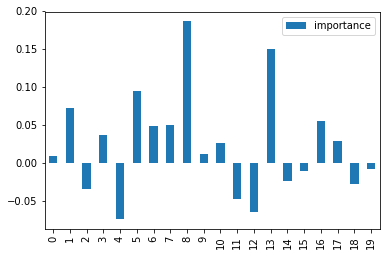

In [47]:
# Baseline model - use the year with most songs data and include genre as a categorical variable (use the same top 3 genres)

# Convert genre to dummy variables

# Use linear regression with same variables as above (sentiment analysis, track metadata, echonest named variable, location)

# IDEA: we will see that genre is a big predictor of track listens - thus, we train separate models for each genre to dig deeper into why that is
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

y = t10[['track_listens']].values
X=t10.drop(['track_listens','track_ID','genre_top'],axis=1).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=7)


linear = LinearRegression()
linear.fit(X_train, y_train)

linear_score=linear.score(X_test, y_test)

print(linear_score)

importances = pd.DataFrame({'feature':t10.drop(['track_listens','track_ID','genre_top'],axis=1).columns,'importance':linear.coef_[0]})
importances.plot.bar()
print(importances)

In [18]:
# For 5-folds, split data into training and testing (one of the genres) - will repeat for other two genres (maybe write function to do this)

# Train linear regression model using all variables

# Regularize using L^1 penalty due to large number of features - pick optimal penalty and compare R^2

# Use GridSearchCV with at least 2-fold validation

# Check resulting model on 5 random folds of data 

# Plot coefficients for resulting model 


,track_ID,latitude,longitude,bit_rate,duration,track_listens,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,artist_hotttnesss,artist_discovery,artist_familiarity,senti neg,senti pos
4,27223,41.87194,12.56738,320000,209,260,0.403708,0.679438,0.732271,0.751735,0.347895,0.0331029,124.293,0.826063,0.414522,0.396793,0.296588,0.000,0.000
5,27224,41.87194,12.56738,320000,126,527,0.717225,0.82488,0.751836,2.59533e-05,0.74028,0.0329309,101.525,0.916406,0.414522,0.396793,0.296588,0.000,0.787
6,27225,41.87194,12.56738,320000,316,486,0.819992,0.521224,0.622387,0.58033,0.134475,0.0321325,87.619,0.522447,0.414522,0.396793,0.296588,0.000,0.000
7,27226,41.87194,12.56738,320000,246,305,0.225266,0.528902,0.888959,0.84172,0.151936,0.0317428,151.781,0.786266,0.414522,0.396793,0.296588,0.000,0.000
8,27227,41.87194,12.56738,320000,129,838,0.876226,0.520132,0.33053,0.0158652,0.0922803,0.0377331,134.329,0.821668,0.414522,0.396793,0.296588,0.706,0.000


C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


9.563117232497698


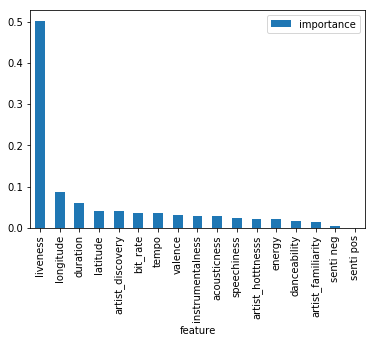

In [25]:
# Train random forest regression model 

# Regularize using L^1 penalty due to large number of features - pick optimal penalty and compare R^2

# Use GridSearchCV with at least 2-fold validation

# Check resulting model on 5 random folds of data 

# Plot coefficients for resulting model 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

y = Rock_10[['track_listens']].values
X=Rock_10.drop(['track_listens','track_ID'],axis=1).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=7)


random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_test, y_test)
acc_random_forest = random_forest.score(X_test, y_test) * 100
print(acc_random_forest)
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID'],axis=1).columns,'importance':random_forest.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

In [ ]:
# Explore adding other features to model, such as nonlinear features (interaction terms)

In [ ]:
# Rock

In [ ]:
# Jazz

In [ ]:
# Hip hop

In [ ]:
# Compare how models are different between different genres - for instance, if certain variables are more or less important for different genres

In [ ]:
# Write function that takes in optimal_model, new song audio and necessary info (like genre, track title, etc.) and uses librosa to extract features
# and output a prediction of number of track listens 

# Load the example clip
# Load 30 seconds of a wav file, starting 15 seconds in
y, sr = librosa.load('blahblah.mp3', offset=15.0, duration=30.0)

# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
hop_length = 512

# Separate harmonics and percussives into two waveforms
y_harmonic, y_percussive = librosa.effects.hpss(y)

# Beat track on the percussive signal
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,
                                             sr=sr)

# Compute MFCC features from the raw signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)

# And the first-order differences (delta features)
mfcc_delta = librosa.feature.delta(mfcc)

# Stack and synchronize between beat events
# This time, we'll use the mean value (default) instead of median
beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]),
                                    beat_frames)

# Compute chroma features from the harmonic signal
chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                        sr=sr)

# Aggregate chroma features between beat events
# We'll use the median value of each feature between beat frames
beat_chroma = librosa.util.sync(chromagram,
                                beat_frames,
                                aggregate=np.median)

# Finally, stack all beat-synchronous features together
beat_features = np.vstack([beat_chroma, beat_mfcc_delta])

In [ ]:
##Statistic for each feature
def columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    # More efficient to slice if indexes are sorted.
    return columns.sort_values()


def feature_stats(name, values):
    features[name, 'mean'] = np.mean(values, axis=1)
    features[name, 'std'] = np.std(values, axis=1)
    features[name, 'skew'] = stats.skew(values, axis=1)
    features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
    features[name, 'median'] = np.median(values, axis=1)
    features[name, 'min'] = np.min(values, axis=1)
    features[name, 'max'] = np.max(values, axis=1)


features = pd.Series(index=columns(), dtype=np.float32)


In [ ]:
##OTHER FEATURES
y, sr = librosa.load('Rough & Laugh.mp3', offset=15.0, duration=30.0)

stft=np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
feature_stats('chroma_stft', f)

f = librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512)
feature_stats('zcr', f)

cqt = np.abs(librosa.cqt(y, sr=sr, hop_length=512, bins_per_octave=12,
                                 n_bins=7*12, tuning=None))
assert cqt.shape[0] == 7 * 12
assert np.ceil(len(y)/512) <= cqt.shape[1] <= np.ceil(len(y)/512)+1


f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
feature_stats('chroma_cqt', f)

f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
feature_stats('chroma_cens', f)

f = librosa.feature.tonnetz(chroma=f)
feature_stats('tonnetz', f)

print(features)